In [18]:
from datasets import load_dataset
from tqdm import tqdm
import torch
import cv2
import numpy as np
   
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Сначала прочитаем все картинки, и создадим новую папку data, в которой разложим наши классы поворотов по папкам

In [19]:
import os
import shutil

def is_file_image(img_formats, file):
    result = False
    for format_ in img_formats:
        if format_ in file:
            result = True
    return result

In [20]:
# удалить папку data, чтобы загрузить туда новые значения
shutil.rmtree('data')
#os.remove('data')

#### наши классы будут называться 0, 90, 180, 270, other 
вращения будем считать по часовой стрелке

In [21]:
#data_folder = "Документы//Из_интернета//SROIE" # receipts
#data_folder = "Документы/Из_интернета/FUNSD/" # documents
data_folder = "Документы//Logstream"

tmp_data = 'data'
classes = ['0', '90', '180', '270', 'other']

if not(os.path.isdir(tmp_data)):
    os.mkdir(tmp_data)
    for class_ in classes:
        if class_ == 'other': # у нас нет примеров для класса "другое"
            continue 
        os.mkdir( os.path.join(tmp_data, class_) )

        
img_formats = ['.jpg', '.png']#['.jpg', '.png']

#copy all images from folder to our subfolder, class '0'
for root, dirs, files in os.walk(data_folder):
    for file in files:
        print(file, is_file_image(img_formats, file))
        if not( is_file_image(img_formats, file) ):
            continue
        shutil.copyfile(os.path.join(root, file), os.path.join(tmp_data, classes[0], file))

1-preprocessed.jpg True
1016.jpg True
1017.jpg True
11-preprocessed.jpg True
13-preprocessed.jpg True
1330.jpg True
17-preprocessed.jpg True
17544.png True
17550.png True
18-preprocessed.jpg True
2-preprocessed.jpg True
2239.jpg True
3-preprocessed.jpg True
4-preprocessed.jpg True
930.jpg True
931.jpg True
932.jpg True
955.jpg True
960.jpg True
961.jpg True
963.jpg True
964.jpg True
bad-r-0002.jpg True
bad-r-0003.jpg True
desktop.ini False
photo_2024-02-28_09-02-11.jpg True
smol.jpg True
t-1.jpg True


In [22]:
from PIL import Image

total_imgs = 0
for file in tqdm(os.listdir( os.path.join(tmp_data, classes[0]) )):
    if file[-4:] == '.jpg':
        img = cv2.imread( os.path.join(tmp_data, classes[0], file) ) # открываем ровный оригинал
    elif file[-4:] == '.png':
        img = Image.open( os.path.join(tmp_data, classes[0], file) )
        img = img.convert('RGB')
        img = np.array(img)
        #continue
        #img = cv2.imread( os.path.join(tmp_data, classes[0], file) , -1)

    # вращаем один раз и сохраняем (90)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite( os.path.join(tmp_data, classes[1], file), img )
    
    # вращаем второй раз и сохраняем (180)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite( os.path.join(tmp_data, classes[2], file), img )
    
    # вращаем третий раз и сохраняем (270)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite( os.path.join(tmp_data, classes[3], file), img )
    
    total_imgs += 4
print("Total Imgs:", total_imgs)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.80it/s]

Total Imgs: 108


In [23]:
from torchvision.models.mobilenetv3 import mobilenet_v3_small
import torch
import torch.nn as nn

In [24]:
model = mobilenet_v3_small()
model.classifier = nn.Sequential(nn.Linear(in_features=576, out_features=1024), 
                                 nn.Hardswish(),
                                 nn.Dropout(p=0.2, inplace=True),
                                 nn.Linear(in_features=1024, out_features=4, bias=True))

In [25]:
model.load_state_dict(torch.load('models//mobile_net//documents.pt', map_location='cpu'))

<All keys matched successfully>

In [26]:
num_epochs = 30
batch_size = 16
learining_rate = 0.001
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learining_rate, weight_decay = 0.001, momentum = 0.9)

In [27]:
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Lambda(lambda x: x.to(device)),
                                transforms.Resize((128,128))])


dataset = datasets.ImageFolder(tmp_data, transform = transform)

print(len(dataset))
total_imgs = len(dataset)

train_percent = 0.8
len_train, len_test = round(total_imgs * train_percent), total_imgs - round(total_imgs*train_percent)
print(len_train, len_test)
train, test = torch.utils.data.random_split(dataset, [len_train, len_test])

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

108
86 22


### в следующей ячейке loss и accuracy НЕ СЧИТАЮТСЯ!
### оно показывает только последний из всего, не среднее!!!

In [31]:
#training statistics
train_loss = []
train_acc = []
test_acc = []

for epoch in range(num_epochs):
    loss_sum = 0
    acc_sum = 0
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        
        output = model(images)
        labels = torch.tensor(labels).to(device)


        loss = criterion(output, labels)
        
        _, predicted = torch.max(output.data, 1)
        #print(((predicted == labels).to('cpu').numpy().mean()))
        acc = ((predicted == labels).to('cpu').numpy().mean())
        
        #train_loss.append(float(loss))
        #train_acc.append(acc)
        loss_sum += float(loss)
        acc_sum += acc
        #train_loss.append()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
    print('Epoch:', epoch, 'Loss:', loss_sum/len(train_loader), 'Acc:', acc_sum/len(train_loader))
    train_loss.append(loss_sum/len(train_loader))
    train_acc.append(acc_sum/len(train_loader))
    
    with torch.no_grad():
        acc_sum = 0
        for (images, labels) in ((test_loader)):
            output = model(images)
            labels = torch.tensor(labels).to(device)
            _, predicted = torch.max(output.data, 1)
            #print(((predicted == labels).to('cpu').numpy().mean()))
            acc = ((predicted == labels).to('cpu').numpy().mean())
            test_acc.append(acc)
            acc_sum += acc
        print("Test acc:", acc_sum/len(test_loader))
        test_acc.append(acc_sum/len(test_loader))
        
        

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_6084\3609555986.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.55s/it]


Epoch: 0 Loss: 0.22494918604691824 Acc: 0.9375


C:\Users\admin\AppData\Local\Temp\ipykernel_6084\3609555986.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Test acc: 0.8541666666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.57s/it]


Epoch: 1 Loss: 0.40305115655064583 Acc: 0.8541666666666666
Test acc: 0.90625


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.51s/it]


Epoch: 2 Loss: 0.22706629087527594 Acc: 0.9201388888888888
Test acc: 0.8020833333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.55s/it]


Epoch: 3 Loss: 0.26211560269196826 Acc: 0.9131944444444445
Test acc: 0.7083333333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.56s/it]


Epoch: 4 Loss: 0.19280307864149412 Acc: 0.9479166666666666
Test acc: 0.7083333333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.52s/it]


Epoch: 5 Loss: 0.45665232588847476 Acc: 0.8576388888888888
Test acc: 0.7604166666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.51s/it]


Epoch: 6 Loss: 0.1756658467153708 Acc: 0.9479166666666666
Test acc: 0.875


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.54s/it]


Epoch: 7 Loss: 0.2359605940679709 Acc: 0.9340277777777778
Test acc: 0.6875


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.53s/it]


Epoch: 8 Loss: 0.19567122807105383 Acc: 0.9409722222222222
Test acc: 0.7395833333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.54s/it]


Epoch: 9 Loss: 0.26048313081264496 Acc: 0.9305555555555555
Test acc: 0.8229166666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.53s/it]


Epoch: 10 Loss: 0.19162294641137123 Acc: 0.9305555555555555
Test acc: 0.8229166666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.53s/it]


Epoch: 11 Loss: 0.2698110391696294 Acc: 0.8993055555555555
Test acc: 0.8229166666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.55s/it]


Epoch: 12 Loss: 0.2641032164295514 Acc: 0.8819444444444445
Test acc: 0.7604166666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.53s/it]


Epoch: 13 Loss: 0.17522651329636574 Acc: 0.9583333333333334
Test acc: 0.8229166666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.55s/it]


Epoch: 14 Loss: 0.34106138224403065 Acc: 0.9305555555555555
Test acc: 0.8541666666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.53s/it]


Epoch: 15 Loss: 0.226046039412419 Acc: 0.9131944444444445
Test acc: 0.7395833333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.53s/it]


Epoch: 16 Loss: 0.19375425080458322 Acc: 0.96875
Test acc: 0.7083333333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.57s/it]


Epoch: 17 Loss: 0.15779132395982742 Acc: 0.9583333333333334
Test acc: 0.7604166666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.56s/it]


Epoch: 18 Loss: 0.19008599345882735 Acc: 0.9513888888888888
Test acc: 0.7395833333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.56s/it]


Epoch: 19 Loss: 0.2635267445196708 Acc: 0.8854166666666666
Test acc: 0.65625


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.48s/it]


Epoch: 20 Loss: 0.1507531019548575 Acc: 0.9895833333333334
Test acc: 0.8229166666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.54s/it]


Epoch: 21 Loss: 0.21214844783147177 Acc: 0.9409722222222222
Test acc: 0.7916666666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.54s/it]


Epoch: 22 Loss: 0.1615422156949838 Acc: 0.9791666666666666
Test acc: 0.8541666666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.58s/it]


Epoch: 23 Loss: 0.12395867456992467 Acc: 1.0
Test acc: 0.8541666666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.53s/it]


Epoch: 24 Loss: 0.2882841577132543 Acc: 0.9375
Test acc: 0.65625


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.53s/it]


Epoch: 25 Loss: 0.2609282024204731 Acc: 0.9618055555555555
Test acc: 0.625


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.57s/it]


Epoch: 26 Loss: 0.1824549858768781 Acc: 0.96875
Test acc: 0.8229166666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.59s/it]


Epoch: 27 Loss: 0.13051518176992735 Acc: 0.9895833333333334
Test acc: 0.71875


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.56s/it]


Epoch: 28 Loss: 0.14384919963777065 Acc: 0.96875
Test acc: 0.7708333333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.54s/it]


Epoch: 29 Loss: 0.23991450294852257 Acc: 0.9201388888888888
Test acc: 0.71875


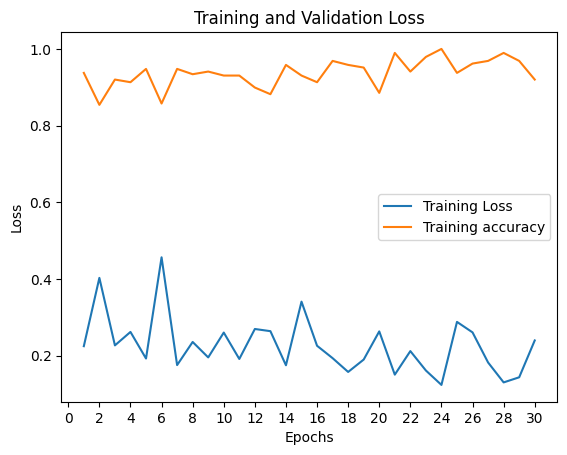

In [33]:
from matplotlib.pylab import plt
from numpy import arange

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, num_epochs+1)

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, train_acc, label='Training accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, num_epochs+1, 2))

# Display the plot
plt.legend(loc='best')
plt.show()

In [76]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))  

Accuracy of the network on the 159 test images: 86.79245283018868 %


In [58]:
torch.save(model.state_dict(), 'models//mobile_net//log.pt')

        doctr         ->   receipts    ->     docs      ->   logstream
"mobilenet_v3_doctr.pt"  "receipts.pt"    "documents.pt"      "log.pt"
                                                86



Trained only on internet documents: 77.5% on itself, 40% on ours

#### Testing on our images

In [7]:
# удалить папку data, чтобы загрузить туда новые значения
shutil.rmtree('data')

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'data'

In [8]:
#data_folder = "Документы//Из_интернета//SROIE" # receipts
#data_folder = "Документы/Из_интернета/FUNSD/" # documents
data_folder = "Документы//Logstream"

tmp_data = 'data'
classes = ['0', '90', '180', '270', 'other']

if not(os.path.isdir(tmp_data)):
    os.mkdir(tmp_data)
    for class_ in classes:
        if class_ == 'other': # у нас нет примеров для класса "другое"
            continue 
        os.mkdir( os.path.join(tmp_data, class_) )

        
img_formats = ['.jpg', '.png']#['.jpg', '.png']

#copy all images from folder to our subfolder, class '0'
for root, dirs, files in os.walk(data_folder):
    for file in files:
        print(file, is_file_image(img_formats, file))
        if not( is_file_image(img_formats, file) ):
            continue
        shutil.copyfile(os.path.join(root, file), os.path.join(tmp_data, classes[0], file))

1-preprocessed.jpg True
1016.jpg True
1017.jpg True
11-preprocessed.jpg True
13-preprocessed.jpg True
1330.jpg True
17-preprocessed.jpg True
17544.png True
17550.png True
18-preprocessed.jpg True
2-preprocessed.jpg True
2239.jpg True
3-preprocessed.jpg True
4-preprocessed.jpg True
930.jpg True
931.jpg True
932.jpg True
955.jpg True
960.jpg True
961.jpg True
963.jpg True
964.jpg True
bad-r-0002.jpg True
bad-r-0003.jpg True
desktop.ini False
photo_2024-02-28_09-02-11.jpg True
smol.jpg True
t-1.jpg True


In [9]:
from PIL import Image

total_imgs = 0
for file in tqdm(os.listdir( os.path.join(tmp_data, classes[0]) )):
    if file[-4:] == '.jpg':
        img = cv2.imread( os.path.join(tmp_data, classes[0], file) ) # открываем ровный оригинал
    elif file[-4:] == '.png':
        img = Image.open( os.path.join(tmp_data, classes[0], file) )
        img = img.convert('RGB')
        img = np.array(img)
        file = file.replace('.png', '.jpg')
        #continue
        #img = cv2.imread( os.path.join(tmp_data, classes[0], file) , -1)

    # вращаем один раз и сохраняем (90)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite( os.path.join(tmp_data, classes[1], file), img )
    
    # вращаем второй раз и сохраняем (180)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite( os.path.join(tmp_data, classes[2], file), img )
    
    # вращаем третий раз и сохраняем (270)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite( os.path.join(tmp_data, classes[3], file), img )
    
    total_imgs += 4
print("Total Imgs:", total_imgs)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:10<00:00,  2.64it/s]

Total Imgs: 108


In [10]:
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Lambda(lambda x: x.to(device)),
                                transforms.Resize((128,128))])

folder = 'data'
dataset = datasets.ImageFolder(folder, transform = transform)

print(len(dataset))
total_imgs = len(dataset)


val_len = total_imgs
print(val_len, 'imgs.')
#val = torch.utils.data.random_split(dataset, [val_len])

val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

108
108 imgs.


In [16]:
import time

t1 = time.time()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))  
    
t2 = time.time()

print("Total time:", (t2 - t1), "s\nTime per image:", (t2-t1)/total, "s")

Accuracy of the network on the 108 test images: 41.666666666666664 %
Total time: 10.899157524108887 s
Time per image: 0.10091812522323043 s


In [15]:
device


'cpu'